In [1]:
%tensorflow_version 1.x

# get the Anaconda file 
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! chmod +x Anaconda3-2019.10-Linux-x86_64.sh
! bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local

! time conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

# install mordred, bravado and molvs
! time conda install -c conda-forge -y mordred bravado molvs

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

!pip install hyperopt

# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')

import json
# import numpy as np
# import pandas as pd
import os
import requests

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_context("poster")
sns.set_style("whitegrid")
sns.set_palette("Set2")

import pandas as pd
import os, json, sys, glob, pickle

TensorFlow 1.x selected.
--2021-04-08 05:51:15--  https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 530308481 (506M) [application/x-sh]
Saving to: ‘Anaconda3-2019.10-Linux-x86_64.sh’

Anaconda3-2019.10-L 100%[===================>] 505.74M   174MB/s    in 2.9s    

2021-04-08 05:51:18 (174 MB/s) - ‘Anaconda3-2019.10-Linux-x86_64.sh’ saved [530308481/530308481]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _ipyw_jlab_nb_ext_conf==0.1.0=py37_0
    - _libgcc_mutex==0.1=main
    - alabaster==0.7.12=py37_0
    - anaconda-client==1.7.2=py37_0
   

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


InvalidVersionSpec: Invalid version '4.19.112+': empty version component


real	0m12.440s
user	0m8.934s
sys	0m2.122s
--2021-04-08 05:59:48--  https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1100 (1.1K) [text/plain]
Saving to: ‘install_AMPL_GPU_test.sh’

install_AMPL_GPU_te 100%[===================>]   1.07

In [2]:
! pip install bravado

     |████████████████████████████████| 71kB 5.7MB/s 
     |████████████████████████████████| 133kB 30.1MB/s 
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-cp37-none-any.whl size=18120 sha256=04c8acecc80740e881c8f2b710ff894cd92861bdf30ef2800c719e5411b46e67
  Stored in directory: /root/.cache/pip/wheels/bb/af/c9/b6e9fb5f9b2470e4ed2a7241c9ab3a8cdd3bc8555ae02ca2e6
Successfully built strict-rfc3339


In [3]:
if 'cffi' in sys.modules:
  del sys.modules['cffi']
import atomsci.ddm.pipeline.compare_models as cmp
from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import parameter_parser as parse
from atomsci.ddm.pipeline import perf_data

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK


In [4]:
from google.colab import files
uploaded = files.upload()

Saving curated_df.csv to curated_df.csv


In [5]:
import io

In [6]:
df = pd.read_csv(io.StringIO(uploaded['curated_df.csv'].decode('utf-8')))

In [7]:
df[df.compound_id.duplicated(keep=False)==True].sort_values(by='compound_id')

,Unnamed: 0,compound_id,base_rdkit_smiles,relation,pXC50,active,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate
1083,1083,CHEMBL114054,Oc1ccc2cccc(NCc3c[nH]cn3)c2c1,>,5.300000,0,5.300000,NaN,0.0,0
343,343,CHEMBL114054,Oc1ccc2cccc(NCc3cnc[nH]3)c2c1,>,5.300000,0,5.300000,NaN,0.0,0
1492,1492,CHEMBL115977,c1ccc(-c2ccno2)c(OCc2cnc[nH]2)c1,>,4.000000,0,4.000000,NaN,0.0,0
953,953,CHEMBL115977,c1ccc(-c2ccno2)c(OCc2c[nH]cn2)c1,>,4.000000,0,4.000000,NaN,0.0,0
349,349,CHEMBL116700,c1ccc(-c2ccccc2OCc2c[nH]cn2)cc1,NaN,5.262854,0,5.262854,NaN,0.0,0
...,...,...,...,...,...,...,...,...,...,...
236,236,CHEMBL454246,CC(C)CC(=O)O[C@H]1/C=C/C=C/C(=O)O[C@H]2[C@@H](...,NaN,6.667562,0,6.667562,NaN,0.0,0
1278,1278,CHEMBL95523,CNC(=O)c1ccccc1N=CC1NCCN1,NaN,6.160000,0,6.160000,NaN,0.0,0
602,602,CHEMBL95523,CNC(=O)c1ccccc1NCC1=NCCN1,NaN,7.480329,1,7.480329,NaN,0.0,0
209,209,CHEMBL97044,O=C(NC1CC1)c1ccccc1NCC1=NCCN1,NaN,6.124999,0,6.124999,NaN,0.0,0


In [8]:
df_grouped = df.groupby('compound_id',as_index=False)['VALUE_NUM_mean'].mean()

In [9]:
df_dedup = df.drop_duplicates('compound_id')
df_dedup = df_dedup.drop('VALUE_NUM_mean',axis=1)

In [10]:
df_combined = df_dedup.merge(df_grouped,left_on='compound_id',right_on='compound_id')

In [11]:
df_combined.to_csv('data_for_model.csv',encoding="utf-8-sig")
files.download('data_for_model.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
df_combined.to_csv('/content/data_for_model.csv')

## Split Data

In [13]:
working_dir='/content'

featurizer = 'ecfp' 
model_type = 'RF'
response_col = ['VALUE_NUM_mean']
smiles_col = 'base_rdkit_smiles'
compound_id = 'compound_id'
train_file = "data_for_model.csv"
params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",   #Boolean flag for using an input file from the LLNL specific datastore system based on a key of dataset_key
        "save_results": "False", # Save model results to MongoDB,
        "prediction_type": "regression",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "previously_split": "False",  # Boolean flag for loading in previously split train, validation, and test csv files
        "split_only": "True",   # indicate splitting of the datasets when running the hyperparameter search
        'split_stategy':'train_valid_test',
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": working_dir
    }

ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

2021-04-08 06:01:35,379 ['split_stategy'] are not part of the accepted list of parameters and will be ignored
2021-04-08 06:01:43,016 Splitting data by scaffold


number of features: 1024


2021-04-08 06:01:44,537 Dataset split table saved to /data_for_model_train_valid_test_scaffold_ea428d91-d76d-48a2-84e7-00ecfb1504e8.csv


In [14]:
listing = glob.glob(os.path.join("/", "/data_for_model_train_valid_test_scaffold_*"))

In [15]:
name = listing[0]
split_uuid = name.split("_")[-1].split(".")[0]
response_col = "VALUE_NUM_mean"
# default : rf_estimators=500, rf_max_features = 32
params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "regression",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "split_uuid": split_uuid,   # UUID for csv file containing train, validation, and test split information
        "previously_split": "True",
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": "ampl_output"
    }

In [16]:
ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

number of features: 1024


2021-04-08 06:01:52,613 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.082 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:01:59,350 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/c7fa69f8-afb0-49d8-8824-7aa91c4a5892/model_metadata.json
2021-04-08 06:01:59,900 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/c7fa69f8-afb0-49d8-8824-7aa91c4a5892/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_c7fa69f8-afb0-49d8-8824-7aa91c4a5892.tar.gz


In [17]:
pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of validation set: {pred_results['r2_score']:.3f}")

R2 score of validation set: 0.481


## Grid search
### Tunable parameters for Random Forest models¶
* rf_estimators: number of estimators to use in random forest models
* rf_max_depth: the maximum depth of a decision tree in the random forest
* rf_max_features: max number of features to split random forest nodes

In [24]:
rfe_choice = [100,200,300,400]
rfd_choice = [16,32,64,128,256]
rff_choice = [30,50,70,90,110]

rfe_list = []
rfd_list = []
rff_list = []
valid_r2_list = []
for rf_estimator in rfe_choice:
    for rf_depth in rfd_choice:
        for rf_feature in rff_choice:
            params["rf_estimators"] = rf_estimator
            params["rf_max_depth"] = rf_depth
            params["rf_max_features"] = rf_feature
            rfe_list.append(rf_estimator)
            rfd_list.append(rf_depth)
            rff_list.append(rf_feature)
            tp = parse.wrapper(params)
            pl = mp.ModelPipeline(tp)
            pl.train_model()
            pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
            pred_results = pred_data.get_prediction_results()
            valid_r2 = pred_results['r2_score']
            valid_r2_list.append(valid_r2)
            print(f"rf_estimators: {rf_estimator}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_r2: {valid_r2}")

number of features: 1024


2021-04-08 06:16:04,951 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.078 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:16:06,701 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/a55a0269-f660-46d7-a045-cd362f2657bc/model_metadata.json
2021-04-08 06:16:06,760 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/a55a0269-f660-46d7-a045-cd362f2657bc/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_a55a0269-f660-46d7-a045-cd362f2657bc.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.4636325573783454
number of features: 1024


2021-04-08 06:16:14,735 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.079 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:16:16,583 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/68d4e734-fa39-49af-a2f9-4c636bc038ad/model_metadata.json
2021-04-08 06:16:16,646 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/68d4e734-fa39-49af-a2f9-4c636bc038ad/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_68d4e734-fa39-49af-a2f9-4c636bc038ad.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 50, valid_r2: 0.47519730600048704
number of features: 1024


2021-04-08 06:16:24,664 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.081 s
Loading dataset from disk.
TIMING: dataset construction took 0.019 s
Loading dataset from disk.
TIMING: dataset construction took 0.018 s
Loading dataset from disk.


2021-04-08 06:16:26,656 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/961868fa-649a-448f-9f33-60a53730d1db/model_metadata.json
2021-04-08 06:16:26,718 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/961868fa-649a-448f-9f33-60a53730d1db/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_961868fa-649a-448f-9f33-60a53730d1db.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 70, valid_r2: 0.4664497766268857
number of features: 1024


2021-04-08 06:16:34,631 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.078 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:16:36,663 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/5f538d65-10cb-4812-be02-3a647754ab02/model_metadata.json
2021-04-08 06:16:36,726 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/5f538d65-10cb-4812-be02-3a647754ab02/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_5f538d65-10cb-4812-be02-3a647754ab02.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 90, valid_r2: 0.48667312538506635
number of features: 1024


2021-04-08 06:16:44,682 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:16:46,841 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/b3ca81e8-f1d5-4f83-ad2c-4b88df26dc73/model_metadata.json
2021-04-08 06:16:46,901 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/b3ca81e8-f1d5-4f83-ad2c-4b88df26dc73/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_b3ca81e8-f1d5-4f83-ad2c-4b88df26dc73.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 110, valid_r2: 0.47199353955308765
number of features: 1024


2021-04-08 06:16:54,999 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.082 s
Loading dataset from disk.
TIMING: dataset construction took 0.018 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:16:57,047 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/a91bb6bf-ddb5-44dc-9e0b-665de8af83a6/model_metadata.json
2021-04-08 06:16:57,151 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/a91bb6bf-ddb5-44dc-9e0b-665de8af83a6/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_a91bb6bf-ddb5-44dc-9e0b-665de8af83a6.tar.gz
rf_estimators: 100, rf_max_depth: 32, rf_max_features: 30, valid_r2: 0.4747102183264743
number of features: 1024


2021-04-08 06:17:05,180 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.078 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:17:07,274 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/2f8cf5bf-919f-4c8e-b1d3-d399ccef5122/model_metadata.json
2021-04-08 06:17:07,381 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/2f8cf5bf-919f-4c8e-b1d3-d399ccef5122/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_2f8cf5bf-919f-4c8e-b1d3-d399ccef5122.tar.gz
rf_estimators: 100, rf_max_depth: 32, rf_max_features: 50, valid_r2: 0.46818401462414627
number of features: 1024


2021-04-08 06:17:15,235 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.079 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:17:17,389 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/b7263660-2a53-4cfb-ad01-4c29bc85ebdf/model_metadata.json
2021-04-08 06:17:17,499 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/b7263660-2a53-4cfb-ad01-4c29bc85ebdf/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_b7263660-2a53-4cfb-ad01-4c29bc85ebdf.tar.gz
rf_estimators: 100, rf_max_depth: 32, rf_max_features: 70, valid_r2: 0.4801100686172769
number of features: 1024


2021-04-08 06:17:25,258 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.076 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:17:27,627 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/f4ba6615-38c6-42a6-abc0-c61794efbcaf/model_metadata.json
2021-04-08 06:17:27,747 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/f4ba6615-38c6-42a6-abc0-c61794efbcaf/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_f4ba6615-38c6-42a6-abc0-c61794efbcaf.tar.gz
rf_estimators: 100, rf_max_depth: 32, rf_max_features: 90, valid_r2: 0.4811101677272318
number of features: 1024


2021-04-08 06:17:35,653 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.073 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:17:38,129 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/f034b77d-9180-4e91-a3c4-d5e02d0bc2a0/model_metadata.json
2021-04-08 06:17:38,232 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/f034b77d-9180-4e91-a3c4-d5e02d0bc2a0/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_f034b77d-9180-4e91-a3c4-d5e02d0bc2a0.tar.gz
rf_estimators: 100, rf_max_depth: 32, rf_max_features: 110, valid_r2: 0.47596021307934855
number of features: 1024


2021-04-08 06:17:46,178 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.123 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.020 s
Loading dataset from disk.


2021-04-08 06:17:48,581 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/32be246a-a79a-4f09-b598-c4e4f67d1b74/model_metadata.json
2021-04-08 06:17:48,713 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/32be246a-a79a-4f09-b598-c4e4f67d1b74/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_32be246a-a79a-4f09-b598-c4e4f67d1b74.tar.gz
rf_estimators: 100, rf_max_depth: 64, rf_max_features: 30, valid_r2: 0.4772202747621298
number of features: 1024


2021-04-08 06:17:57,547 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.081 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:17:59,767 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/b722957c-14a6-4401-9cdf-4be1c65b9efa/model_metadata.json
2021-04-08 06:17:59,888 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/b722957c-14a6-4401-9cdf-4be1c65b9efa/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_b722957c-14a6-4401-9cdf-4be1c65b9efa.tar.gz
rf_estimators: 100, rf_max_depth: 64, rf_max_features: 50, valid_r2: 0.46547129807663656
number of features: 1024


2021-04-08 06:18:07,869 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.078 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:18:10,282 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/2b5c396d-f8f8-4313-bcef-22c03818f1cf/model_metadata.json
2021-04-08 06:18:10,402 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/2b5c396d-f8f8-4313-bcef-22c03818f1cf/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_2b5c396d-f8f8-4313-bcef-22c03818f1cf.tar.gz
rf_estimators: 100, rf_max_depth: 64, rf_max_features: 70, valid_r2: 0.4804125229787859
number of features: 1024


2021-04-08 06:18:18,392 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.077 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.020 s
Loading dataset from disk.


2021-04-08 06:18:20,800 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/f6990477-f531-4f2d-a8e7-796447466e65/model_metadata.json
2021-04-08 06:18:20,926 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/f6990477-f531-4f2d-a8e7-796447466e65/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_f6990477-f531-4f2d-a8e7-796447466e65.tar.gz
rf_estimators: 100, rf_max_depth: 64, rf_max_features: 90, valid_r2: 0.47740970383830084
number of features: 1024


2021-04-08 06:18:28,844 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.081 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.019 s
Loading dataset from disk.


2021-04-08 06:18:31,451 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/deeb6984-6c1e-48d5-850e-ca5d0333853b/model_metadata.json
2021-04-08 06:18:31,574 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/deeb6984-6c1e-48d5-850e-ca5d0333853b/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_deeb6984-6c1e-48d5-850e-ca5d0333853b.tar.gz
rf_estimators: 100, rf_max_depth: 64, rf_max_features: 110, valid_r2: 0.5063247590058628
number of features: 1024


2021-04-08 06:18:42,306 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.117 s
Loading dataset from disk.
TIMING: dataset construction took 0.025 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.


2021-04-08 06:18:44,628 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/498ab531-ae54-4b0d-b95c-a81ff7b77b33/model_metadata.json
2021-04-08 06:18:44,748 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/498ab531-ae54-4b0d-b95c-a81ff7b77b33/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_498ab531-ae54-4b0d-b95c-a81ff7b77b33.tar.gz
rf_estimators: 100, rf_max_depth: 128, rf_max_features: 30, valid_r2: 0.48219113870452024
number of features: 1024


2021-04-08 06:18:52,733 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.080 s
Loading dataset from disk.
TIMING: dataset construction took 0.020 s
Loading dataset from disk.
TIMING: dataset construction took 0.018 s
Loading dataset from disk.


2021-04-08 06:18:54,952 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/026486e7-a411-460e-bec3-c6587d47b066/model_metadata.json
2021-04-08 06:18:55,076 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/026486e7-a411-460e-bec3-c6587d47b066/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_026486e7-a411-460e-bec3-c6587d47b066.tar.gz
rf_estimators: 100, rf_max_depth: 128, rf_max_features: 50, valid_r2: 0.5067940605839312
number of features: 1024


2021-04-08 06:19:03,083 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.079 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:19:05,416 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/b2a8c46a-521c-4944-bbe8-1d363de9c47d/model_metadata.json
2021-04-08 06:19:05,543 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/b2a8c46a-521c-4944-bbe8-1d363de9c47d/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_b2a8c46a-521c-4944-bbe8-1d363de9c47d.tar.gz
rf_estimators: 100, rf_max_depth: 128, rf_max_features: 70, valid_r2: 0.48991301489840056
number of features: 1024


2021-04-08 06:19:13,536 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.082 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:19:16,054 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/20bdc218-a776-4941-8d89-79e626a37ab0/model_metadata.json
2021-04-08 06:19:16,176 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/20bdc218-a776-4941-8d89-79e626a37ab0/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_20bdc218-a776-4941-8d89-79e626a37ab0.tar.gz
rf_estimators: 100, rf_max_depth: 128, rf_max_features: 90, valid_r2: 0.4819885234129725
number of features: 1024


2021-04-08 06:19:24,185 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.075 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:19:26,774 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/7bd7c688-048e-4843-ab97-3ceeae0b45cd/model_metadata.json
2021-04-08 06:19:26,893 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/7bd7c688-048e-4843-ab97-3ceeae0b45cd/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_7bd7c688-048e-4843-ab97-3ceeae0b45cd.tar.gz
rf_estimators: 100, rf_max_depth: 128, rf_max_features: 110, valid_r2: 0.4892730068240968
number of features: 1024


2021-04-08 06:19:34,680 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.074 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:19:36,761 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/7a4f5e37-d936-4cc3-ab50-7c5b8b94ffa9/model_metadata.json
2021-04-08 06:19:36,886 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/7a4f5e37-d936-4cc3-ab50-7c5b8b94ffa9/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_7a4f5e37-d936-4cc3-ab50-7c5b8b94ffa9.tar.gz
rf_estimators: 100, rf_max_depth: 256, rf_max_features: 30, valid_r2: 0.48792757120196584
number of features: 1024


2021-04-08 06:19:44,724 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.084 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:19:46,968 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/daf8e148-5da3-4614-893f-d057091b28d6/model_metadata.json
2021-04-08 06:19:47,092 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/daf8e148-5da3-4614-893f-d057091b28d6/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_daf8e148-5da3-4614-893f-d057091b28d6.tar.gz
rf_estimators: 100, rf_max_depth: 256, rf_max_features: 50, valid_r2: 0.47330999384245553
number of features: 1024


2021-04-08 06:19:55,101 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.083 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:19:57,443 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/36a81785-d22d-42bc-a038-11f49dcd91d4/model_metadata.json
2021-04-08 06:19:57,576 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/36a81785-d22d-42bc-a038-11f49dcd91d4/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_36a81785-d22d-42bc-a038-11f49dcd91d4.tar.gz
rf_estimators: 100, rf_max_depth: 256, rf_max_features: 70, valid_r2: 0.4909739984138759
number of features: 1024


2021-04-08 06:20:05,777 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.090 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.018 s
Loading dataset from disk.


2021-04-08 06:20:08,354 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/48ac5cd9-66dd-4f98-a45b-5c19f533048c/model_metadata.json
2021-04-08 06:20:08,483 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/48ac5cd9-66dd-4f98-a45b-5c19f533048c/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_48ac5cd9-66dd-4f98-a45b-5c19f533048c.tar.gz
rf_estimators: 100, rf_max_depth: 256, rf_max_features: 90, valid_r2: 0.4809609741616627
number of features: 1024


2021-04-08 06:20:16,707 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.018 s
Loading dataset from disk.


2021-04-08 06:20:19,336 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/c40158e9-9884-4fa2-91dc-78a0eaf625c3/model_metadata.json
2021-04-08 06:20:19,460 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/c40158e9-9884-4fa2-91dc-78a0eaf625c3/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_c40158e9-9884-4fa2-91dc-78a0eaf625c3.tar.gz
rf_estimators: 100, rf_max_depth: 256, rf_max_features: 110, valid_r2: 0.48868927046055566
number of features: 1024


2021-04-08 06:20:27,659 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.079 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:20:29,949 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/7ce56888-464e-4a54-b9e4-f7bda28316a7/model_metadata.json
2021-04-08 06:20:30,072 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/7ce56888-464e-4a54-b9e4-f7bda28316a7/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_7ce56888-464e-4a54-b9e4-f7bda28316a7.tar.gz
rf_estimators: 200, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.45854172321331543
number of features: 1024


2021-04-08 06:20:38,031 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.079 s
Loading dataset from disk.
TIMING: dataset construction took 0.018 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:20:40,609 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/3fd321c2-a0db-4ca2-9c58-ab3d01744117/model_metadata.json
2021-04-08 06:20:40,727 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/3fd321c2-a0db-4ca2-9c58-ab3d01744117/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_3fd321c2-a0db-4ca2-9c58-ab3d01744117.tar.gz
rf_estimators: 200, rf_max_depth: 16, rf_max_features: 50, valid_r2: 0.46822270295058355
number of features: 1024


2021-04-08 06:20:48,778 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.079 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:20:51,583 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/261732eb-5b33-470d-93a9-a29acda4f3e9/model_metadata.json
2021-04-08 06:20:51,697 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/261732eb-5b33-470d-93a9-a29acda4f3e9/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_261732eb-5b33-470d-93a9-a29acda4f3e9.tar.gz
rf_estimators: 200, rf_max_depth: 16, rf_max_features: 70, valid_r2: 0.4869888024226048
number of features: 1024


2021-04-08 06:21:00,055 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.084 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:21:02,969 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/204cc0da-3ff1-48c5-8f50-cc5ade417112/model_metadata.json
2021-04-08 06:21:03,090 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/204cc0da-3ff1-48c5-8f50-cc5ade417112/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_204cc0da-3ff1-48c5-8f50-cc5ade417112.tar.gz
rf_estimators: 200, rf_max_depth: 16, rf_max_features: 90, valid_r2: 0.48275489240193514
number of features: 1024


2021-04-08 06:21:11,123 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.075 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:21:14,321 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/78f02902-a0b4-4fa9-87af-7862146a7ee8/model_metadata.json
2021-04-08 06:21:14,448 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/78f02902-a0b4-4fa9-87af-7862146a7ee8/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_78f02902-a0b4-4fa9-87af-7862146a7ee8.tar.gz
rf_estimators: 200, rf_max_depth: 16, rf_max_features: 110, valid_r2: 0.496677151395545
number of features: 1024


2021-04-08 06:21:22,552 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.075 s
Loading dataset from disk.
TIMING: dataset construction took 0.019 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:21:25,463 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/c52a2ba7-d1cc-4ded-be9d-3f52661130a4/model_metadata.json
2021-04-08 06:21:25,673 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/c52a2ba7-d1cc-4ded-be9d-3f52661130a4/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_c52a2ba7-d1cc-4ded-be9d-3f52661130a4.tar.gz
rf_estimators: 200, rf_max_depth: 32, rf_max_features: 30, valid_r2: 0.4959186650306985
number of features: 1024


2021-04-08 06:21:33,590 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.076 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:21:36,857 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/b2d95a1b-f374-463c-af1c-96b173cfeb82/model_metadata.json
2021-04-08 06:21:37,064 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/b2d95a1b-f374-463c-af1c-96b173cfeb82/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_b2d95a1b-f374-463c-af1c-96b173cfeb82.tar.gz
rf_estimators: 200, rf_max_depth: 32, rf_max_features: 50, valid_r2: 0.4855112266956403
number of features: 1024


2021-04-08 06:21:45,180 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.081 s
Loading dataset from disk.
TIMING: dataset construction took 0.020 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:21:48,755 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/918e95f7-2dac-40ec-9075-ed1f070abbe0/model_metadata.json
2021-04-08 06:21:48,969 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/918e95f7-2dac-40ec-9075-ed1f070abbe0/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_918e95f7-2dac-40ec-9075-ed1f070abbe0.tar.gz
rf_estimators: 200, rf_max_depth: 32, rf_max_features: 70, valid_r2: 0.485779517093748
number of features: 1024


2021-04-08 06:21:57,399 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.083 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:22:01,140 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/eb0d3c3a-f86d-40be-a966-862f73628401/model_metadata.json
2021-04-08 06:22:01,349 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/eb0d3c3a-f86d-40be-a966-862f73628401/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_eb0d3c3a-f86d-40be-a966-862f73628401.tar.gz
rf_estimators: 200, rf_max_depth: 32, rf_max_features: 90, valid_r2: 0.4899723663807677
number of features: 1024


2021-04-08 06:22:09,488 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.084 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:22:13,475 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/cb94cc3f-fcf4-4c94-a392-e518123a5489/model_metadata.json
2021-04-08 06:22:13,680 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/cb94cc3f-fcf4-4c94-a392-e518123a5489/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_cb94cc3f-fcf4-4c94-a392-e518123a5489.tar.gz
rf_estimators: 200, rf_max_depth: 32, rf_max_features: 110, valid_r2: 0.5046606676326537
number of features: 1024


2021-04-08 06:22:21,897 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.085 s
Loading dataset from disk.
TIMING: dataset construction took 0.018 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:22:25,241 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/1409af8b-c1d2-40c9-b2d3-d927a127fd85/model_metadata.json
2021-04-08 06:22:25,489 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/1409af8b-c1d2-40c9-b2d3-d927a127fd85/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_1409af8b-c1d2-40c9-b2d3-d927a127fd85.tar.gz
rf_estimators: 200, rf_max_depth: 64, rf_max_features: 30, valid_r2: 0.4792111523059841
number of features: 1024


2021-04-08 06:22:33,846 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.077 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.018 s
Loading dataset from disk.


2021-04-08 06:22:37,438 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/a57e8f83-5241-4018-a6cc-99b941d76354/model_metadata.json
2021-04-08 06:22:37,690 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/a57e8f83-5241-4018-a6cc-99b941d76354/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_a57e8f83-5241-4018-a6cc-99b941d76354.tar.gz
rf_estimators: 200, rf_max_depth: 64, rf_max_features: 50, valid_r2: 0.48328067046555967
number of features: 1024


2021-04-08 06:22:45,961 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.077 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:22:49,657 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/67dd4e96-8208-41a5-92d6-dbe70b82ac35/model_metadata.json
2021-04-08 06:22:49,897 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/67dd4e96-8208-41a5-92d6-dbe70b82ac35/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_67dd4e96-8208-41a5-92d6-dbe70b82ac35.tar.gz
rf_estimators: 200, rf_max_depth: 64, rf_max_features: 70, valid_r2: 0.48665035076810237
number of features: 1024


2021-04-08 06:22:57,788 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.076 s
Loading dataset from disk.
TIMING: dataset construction took 0.020 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:23:01,627 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/109a5821-7a78-487f-b18b-2de8d3280c78/model_metadata.json
2021-04-08 06:23:01,856 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/109a5821-7a78-487f-b18b-2de8d3280c78/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_109a5821-7a78-487f-b18b-2de8d3280c78.tar.gz
rf_estimators: 200, rf_max_depth: 64, rf_max_features: 90, valid_r2: 0.48266611604566234
number of features: 1024


2021-04-08 06:23:09,703 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.079 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:23:13,873 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/1b3bbfb1-78dc-4c47-938b-ba0159eefe4c/model_metadata.json
2021-04-08 06:23:14,104 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/1b3bbfb1-78dc-4c47-938b-ba0159eefe4c/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_1b3bbfb1-78dc-4c47-938b-ba0159eefe4c.tar.gz
rf_estimators: 200, rf_max_depth: 64, rf_max_features: 110, valid_r2: 0.5057257948434202
number of features: 1024


2021-04-08 06:23:22,175 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.078 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:23:25,458 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/72d566c2-b087-4a5a-be25-9262cf3a1f51/model_metadata.json
2021-04-08 06:23:25,704 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/72d566c2-b087-4a5a-be25-9262cf3a1f51/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_72d566c2-b087-4a5a-be25-9262cf3a1f51.tar.gz
rf_estimators: 200, rf_max_depth: 128, rf_max_features: 30, valid_r2: 0.4843880576995412
number of features: 1024


2021-04-08 06:23:33,888 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.084 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:23:37,402 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/b24d1c67-c64d-4fd9-98ae-e8343d9397c4/model_metadata.json
2021-04-08 06:23:37,640 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/b24d1c67-c64d-4fd9-98ae-e8343d9397c4/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_b24d1c67-c64d-4fd9-98ae-e8343d9397c4.tar.gz
rf_estimators: 200, rf_max_depth: 128, rf_max_features: 50, valid_r2: 0.48003505115183587
number of features: 1024


2021-04-08 06:23:45,383 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.078 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.


2021-04-08 06:23:49,010 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/38e551cb-b78b-4ac6-a6ac-64be42ce909f/model_metadata.json
2021-04-08 06:23:49,236 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/38e551cb-b78b-4ac6-a6ac-64be42ce909f/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_38e551cb-b78b-4ac6-a6ac-64be42ce909f.tar.gz
rf_estimators: 200, rf_max_depth: 128, rf_max_features: 70, valid_r2: 0.4911997379305141
number of features: 1024


2021-04-08 06:23:57,127 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.075 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.


2021-04-08 06:24:00,937 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/ed8fb146-b335-4de8-bc7f-ac50968d4dbd/model_metadata.json
2021-04-08 06:24:01,165 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/ed8fb146-b335-4de8-bc7f-ac50968d4dbd/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_ed8fb146-b335-4de8-bc7f-ac50968d4dbd.tar.gz
rf_estimators: 200, rf_max_depth: 128, rf_max_features: 90, valid_r2: 0.4838817595576115
number of features: 1024


2021-04-08 06:24:08,986 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.082 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.020 s
Loading dataset from disk.


2021-04-08 06:24:13,141 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/a735267e-e9a2-4ef5-b359-0521dee29661/model_metadata.json
2021-04-08 06:24:13,361 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/a735267e-e9a2-4ef5-b359-0521dee29661/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_a735267e-e9a2-4ef5-b359-0521dee29661.tar.gz
rf_estimators: 200, rf_max_depth: 128, rf_max_features: 110, valid_r2: 0.47404126940389235
number of features: 1024


2021-04-08 06:24:21,022 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.080 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:24:24,157 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/58fcdf84-2eb0-4e67-9ddd-7101afd50e5b/model_metadata.json
2021-04-08 06:24:24,402 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/58fcdf84-2eb0-4e67-9ddd-7101afd50e5b/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_58fcdf84-2eb0-4e67-9ddd-7101afd50e5b.tar.gz
rf_estimators: 200, rf_max_depth: 256, rf_max_features: 30, valid_r2: 0.4772657141095
number of features: 1024


2021-04-08 06:24:32,116 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.077 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:24:35,614 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/0ac435a2-8224-42d1-a451-54dd7ff69d3b/model_metadata.json
2021-04-08 06:24:35,856 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/0ac435a2-8224-42d1-a451-54dd7ff69d3b/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_0ac435a2-8224-42d1-a451-54dd7ff69d3b.tar.gz
rf_estimators: 200, rf_max_depth: 256, rf_max_features: 50, valid_r2: 0.4779731629331555
number of features: 1024


2021-04-08 06:24:43,794 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.079 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.


2021-04-08 06:24:47,405 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/dfcda985-4020-419c-8c58-ea8736fe4877/model_metadata.json
2021-04-08 06:24:47,630 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/dfcda985-4020-419c-8c58-ea8736fe4877/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_dfcda985-4020-419c-8c58-ea8736fe4877.tar.gz
rf_estimators: 200, rf_max_depth: 256, rf_max_features: 70, valid_r2: 0.48030199261159323
number of features: 1024


2021-04-08 06:24:55,357 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.076 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.


2021-04-08 06:24:59,191 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/ba07f588-94c5-4229-9aa3-202135538c86/model_metadata.json
2021-04-08 06:24:59,423 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/ba07f588-94c5-4229-9aa3-202135538c86/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_ba07f588-94c5-4229-9aa3-202135538c86.tar.gz
rf_estimators: 200, rf_max_depth: 256, rf_max_features: 90, valid_r2: 0.4931294325097757
number of features: 1024


2021-04-08 06:25:07,294 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.078 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.


2021-04-08 06:25:11,559 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/3a596218-3681-4433-9769-055243b6d7db/model_metadata.json
2021-04-08 06:25:11,799 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/3a596218-3681-4433-9769-055243b6d7db/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_3a596218-3681-4433-9769-055243b6d7db.tar.gz
rf_estimators: 200, rf_max_depth: 256, rf_max_features: 110, valid_r2: 0.48011155930126603
number of features: 1024


2021-04-08 06:25:20,203 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.075 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.


2021-04-08 06:25:23,197 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/9f771cfe-6a0d-460b-9bd8-2d436c633b7d/model_metadata.json
2021-04-08 06:25:23,361 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/9f771cfe-6a0d-460b-9bd8-2d436c633b7d/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_9f771cfe-6a0d-460b-9bd8-2d436c633b7d.tar.gz
rf_estimators: 300, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.45966696256473494
number of features: 1024


2021-04-08 06:25:31,081 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.081 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.018 s
Loading dataset from disk.


2021-04-08 06:25:34,298 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/209b9e91-d344-42c9-8a54-d920838dec6d/model_metadata.json
2021-04-08 06:25:34,473 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/209b9e91-d344-42c9-8a54-d920838dec6d/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_209b9e91-d344-42c9-8a54-d920838dec6d.tar.gz
rf_estimators: 300, rf_max_depth: 16, rf_max_features: 50, valid_r2: 0.4799968195152753
number of features: 1024


2021-04-08 06:25:42,276 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.071 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.


2021-04-08 06:25:45,769 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/93b5ba0b-38a5-4c5f-a160-d4f450893a8d/model_metadata.json
2021-04-08 06:25:45,937 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/93b5ba0b-38a5-4c5f-a160-d4f450893a8d/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_93b5ba0b-38a5-4c5f-a160-d4f450893a8d.tar.gz
rf_estimators: 300, rf_max_depth: 16, rf_max_features: 70, valid_r2: 0.4774713598038578
number of features: 1024


2021-04-08 06:25:53,560 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.075 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.


2021-04-08 06:25:57,472 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/0fdd8b9f-a4ac-4387-a4d5-07826654b6eb/model_metadata.json
2021-04-08 06:25:57,640 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/0fdd8b9f-a4ac-4387-a4d5-07826654b6eb/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_0fdd8b9f-a4ac-4387-a4d5-07826654b6eb.tar.gz
rf_estimators: 300, rf_max_depth: 16, rf_max_features: 90, valid_r2: 0.48486179742501556
number of features: 1024


2021-04-08 06:26:05,346 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.080 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.


2021-04-08 06:26:09,533 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/e6a23c1c-182b-4a2b-b8b4-afcb370a0fc3/model_metadata.json
2021-04-08 06:26:09,703 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/e6a23c1c-182b-4a2b-b8b4-afcb370a0fc3/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_e6a23c1c-182b-4a2b-b8b4-afcb370a0fc3.tar.gz
rf_estimators: 300, rf_max_depth: 16, rf_max_features: 110, valid_r2: 0.49016076109078677
number of features: 1024


2021-04-08 06:26:17,417 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.077 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.


2021-04-08 06:26:21,325 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/430d0b1e-a83a-49e4-8500-bb28e353783b/model_metadata.json
2021-04-08 06:26:21,623 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/430d0b1e-a83a-49e4-8500-bb28e353783b/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_430d0b1e-a83a-49e4-8500-bb28e353783b.tar.gz
rf_estimators: 300, rf_max_depth: 32, rf_max_features: 30, valid_r2: 0.4753348564766662
number of features: 1024


2021-04-08 06:26:29,542 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.080 s
Loading dataset from disk.
TIMING: dataset construction took 0.018 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:26:34,014 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/16a9b0c2-e6a3-4732-9110-358a678a5658/model_metadata.json
2021-04-08 06:26:34,319 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/16a9b0c2-e6a3-4732-9110-358a678a5658/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_16a9b0c2-e6a3-4732-9110-358a678a5658.tar.gz
rf_estimators: 300, rf_max_depth: 32, rf_max_features: 50, valid_r2: 0.48766011504378515
number of features: 1024


2021-04-08 06:26:42,585 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.084 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:26:47,625 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/f9f78b7e-b272-474a-9339-a21d1b87c190/model_metadata.json
2021-04-08 06:26:47,931 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/f9f78b7e-b272-474a-9339-a21d1b87c190/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_f9f78b7e-b272-474a-9339-a21d1b87c190.tar.gz
rf_estimators: 300, rf_max_depth: 32, rf_max_features: 70, valid_r2: 0.48272512623064967
number of features: 1024


2021-04-08 06:26:55,946 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.077 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:27:00,986 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/e46d69b4-48b5-49af-9bf0-49090e246a8f/model_metadata.json
2021-04-08 06:27:01,293 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/e46d69b4-48b5-49af-9bf0-49090e246a8f/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_e46d69b4-48b5-49af-9bf0-49090e246a8f.tar.gz
rf_estimators: 300, rf_max_depth: 32, rf_max_features: 90, valid_r2: 0.49398990088909744
number of features: 1024


2021-04-08 06:27:09,247 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.075 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.


2021-04-08 06:27:14,794 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/20b9452e-9e9f-484e-bc2d-61c4575dd69a/model_metadata.json
2021-04-08 06:27:15,114 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/20b9452e-9e9f-484e-bc2d-61c4575dd69a/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_20b9452e-9e9f-484e-bc2d-61c4575dd69a.tar.gz
rf_estimators: 300, rf_max_depth: 32, rf_max_features: 110, valid_r2: 0.5014949623613096
number of features: 1024


2021-04-08 06:27:22,985 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.076 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.


2021-04-08 06:27:27,167 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/808938c0-e5a1-4bc0-a2e7-a26e7220a91e/model_metadata.json
2021-04-08 06:27:27,504 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/808938c0-e5a1-4bc0-a2e7-a26e7220a91e/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_808938c0-e5a1-4bc0-a2e7-a26e7220a91e.tar.gz
rf_estimators: 300, rf_max_depth: 64, rf_max_features: 30, valid_r2: 0.4794132651373456
number of features: 1024


2021-04-08 06:27:35,227 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.082 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.


2021-04-08 06:27:39,885 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/5fdd904b-f128-4123-a7d8-f52af2e74f17/model_metadata.json
2021-04-08 06:27:40,224 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/5fdd904b-f128-4123-a7d8-f52af2e74f17/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_5fdd904b-f128-4123-a7d8-f52af2e74f17.tar.gz
rf_estimators: 300, rf_max_depth: 64, rf_max_features: 50, valid_r2: 0.46230850221402
number of features: 1024


2021-04-08 06:27:47,951 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.078 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
TIMING: dataset construction took 0.020 s
Loading dataset from disk.


2021-04-08 06:27:52,883 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/63593011-fe81-475c-a14b-9701b4a29b0d/model_metadata.json
2021-04-08 06:27:53,222 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/63593011-fe81-475c-a14b-9701b4a29b0d/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_63593011-fe81-475c-a14b-9701b4a29b0d.tar.gz
rf_estimators: 300, rf_max_depth: 64, rf_max_features: 70, valid_r2: 0.48647961136000106
number of features: 1024


2021-04-08 06:28:01,004 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.076 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:28:06,486 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/956bfd3c-e6cc-4598-908c-c91a1d843fae/model_metadata.json
2021-04-08 06:28:06,812 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/956bfd3c-e6cc-4598-908c-c91a1d843fae/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_956bfd3c-e6cc-4598-908c-c91a1d843fae.tar.gz
rf_estimators: 300, rf_max_depth: 64, rf_max_features: 90, valid_r2: 0.49546192087525465
number of features: 1024


2021-04-08 06:28:14,755 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.084 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:28:20,536 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/69b14932-bff1-481b-9873-a1dc8efec0f0/model_metadata.json
2021-04-08 06:28:20,881 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/69b14932-bff1-481b-9873-a1dc8efec0f0/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_69b14932-bff1-481b-9873-a1dc8efec0f0.tar.gz
rf_estimators: 300, rf_max_depth: 64, rf_max_features: 110, valid_r2: 0.4902420607029766
number of features: 1024


2021-04-08 06:28:29,127 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.084 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:28:33,709 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/6ccd4e09-ec91-455e-84a2-ab3c33f3d6f5/model_metadata.json
2021-04-08 06:28:34,061 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/6ccd4e09-ec91-455e-84a2-ab3c33f3d6f5/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_6ccd4e09-ec91-455e-84a2-ab3c33f3d6f5.tar.gz
rf_estimators: 300, rf_max_depth: 128, rf_max_features: 30, valid_r2: 0.49021402945136494
number of features: 1024


2021-04-08 06:28:41,738 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.072 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:28:46,873 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/4e6847d7-a6bc-4e7b-aaba-73eb29dced60/model_metadata.json
2021-04-08 06:28:47,399 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/4e6847d7-a6bc-4e7b-aaba-73eb29dced60/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_4e6847d7-a6bc-4e7b-aaba-73eb29dced60.tar.gz
rf_estimators: 300, rf_max_depth: 128, rf_max_features: 50, valid_r2: 0.4896364330001651
number of features: 1024


2021-04-08 06:28:58,445 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.075 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:29:03,514 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/36018dcd-739e-4a61-83ae-4a7b861ffde2/model_metadata.json
2021-04-08 06:29:03,873 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/36018dcd-739e-4a61-83ae-4a7b861ffde2/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_36018dcd-739e-4a61-83ae-4a7b861ffde2.tar.gz
rf_estimators: 300, rf_max_depth: 128, rf_max_features: 70, valid_r2: 0.4794685427123738
number of features: 1024


2021-04-08 06:29:11,963 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.083 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:29:17,619 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/844bf44c-2786-4dee-ba28-da31cd0dd1b1/model_metadata.json
2021-04-08 06:29:17,998 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/844bf44c-2786-4dee-ba28-da31cd0dd1b1/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_844bf44c-2786-4dee-ba28-da31cd0dd1b1.tar.gz
rf_estimators: 300, rf_max_depth: 128, rf_max_features: 90, valid_r2: 0.4850581646251263
number of features: 1024


2021-04-08 06:29:26,455 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.084 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:29:32,369 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/e6fb55d4-605a-4d94-a459-086b597b18ba/model_metadata.json
2021-04-08 06:29:32,696 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/e6fb55d4-605a-4d94-a459-086b597b18ba/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_e6fb55d4-605a-4d94-a459-086b597b18ba.tar.gz
rf_estimators: 300, rf_max_depth: 128, rf_max_features: 110, valid_r2: 0.5055173609176988
number of features: 1024


2021-04-08 06:29:40,361 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.076 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.


2021-04-08 06:29:44,624 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/3462f3c5-e790-451b-a885-8b4f78844b1a/model_metadata.json
2021-04-08 06:29:44,962 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/3462f3c5-e790-451b-a885-8b4f78844b1a/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_3462f3c5-e790-451b-a885-8b4f78844b1a.tar.gz
rf_estimators: 300, rf_max_depth: 256, rf_max_features: 30, valid_r2: 0.47486960316871896
number of features: 1024


2021-04-08 06:29:52,618 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.072 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:29:57,264 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/ab77cbbf-49ac-420d-a5e1-ea8916d41c0c/model_metadata.json
2021-04-08 06:29:57,598 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/ab77cbbf-49ac-420d-a5e1-ea8916d41c0c/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_ab77cbbf-49ac-420d-a5e1-ea8916d41c0c.tar.gz
rf_estimators: 300, rf_max_depth: 256, rf_max_features: 50, valid_r2: 0.4928128578050912
number of features: 1024


2021-04-08 06:30:05,375 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:30:10,523 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/3f743f8c-dfc2-4a2a-9eb5-b468e4bfab1a/model_metadata.json
2021-04-08 06:30:10,876 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/3f743f8c-dfc2-4a2a-9eb5-b468e4bfab1a/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_3f743f8c-dfc2-4a2a-9eb5-b468e4bfab1a.tar.gz
rf_estimators: 300, rf_max_depth: 256, rf_max_features: 70, valid_r2: 0.4952762235544643
number of features: 1024


2021-04-08 06:30:19,173 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.074 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:30:24,551 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/9c10b17a-ef06-41ba-a467-8553aa3effe5/model_metadata.json
2021-04-08 06:30:24,897 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/9c10b17a-ef06-41ba-a467-8553aa3effe5/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_9c10b17a-ef06-41ba-a467-8553aa3effe5.tar.gz
rf_estimators: 300, rf_max_depth: 256, rf_max_features: 90, valid_r2: 0.48965828273700285
number of features: 1024


2021-04-08 06:30:32,800 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.083 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.


2021-04-08 06:30:38,562 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/25111c4c-2ca1-44f1-ad49-45bc0808090d/model_metadata.json
2021-04-08 06:30:38,893 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/25111c4c-2ca1-44f1-ad49-45bc0808090d/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_25111c4c-2ca1-44f1-ad49-45bc0808090d.tar.gz
rf_estimators: 300, rf_max_depth: 256, rf_max_features: 110, valid_r2: 0.47908972141347783
number of features: 1024


2021-04-08 06:30:46,848 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.081 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:30:50,675 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/3aa0d872-e9fe-47e0-845d-94116d5e188c/model_metadata.json
2021-04-08 06:30:50,907 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/3aa0d872-e9fe-47e0-845d-94116d5e188c/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_3aa0d872-e9fe-47e0-845d-94116d5e188c.tar.gz
rf_estimators: 400, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.46392485694737606
number of features: 1024


2021-04-08 06:30:59,022 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.084 s
Loading dataset from disk.
TIMING: dataset construction took 0.019 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:31:03,357 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/73eb571e-d261-4acf-95a4-068badab0e4b/model_metadata.json
2021-04-08 06:31:03,593 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/73eb571e-d261-4acf-95a4-068badab0e4b/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_73eb571e-d261-4acf-95a4-068badab0e4b.tar.gz
rf_estimators: 400, rf_max_depth: 16, rf_max_features: 50, valid_r2: 0.47996957963966136
number of features: 1024


2021-04-08 06:31:12,016 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.080 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.019 s
Loading dataset from disk.


2021-04-08 06:31:17,000 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/0bb02a64-d309-48e1-900a-ccb1b6f122ad/model_metadata.json
2021-04-08 06:31:17,245 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/0bb02a64-d309-48e1-900a-ccb1b6f122ad/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_0bb02a64-d309-48e1-900a-ccb1b6f122ad.tar.gz
rf_estimators: 400, rf_max_depth: 16, rf_max_features: 70, valid_r2: 0.4835031546649974
number of features: 1024


2021-04-08 06:31:25,201 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.072 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.


2021-04-08 06:31:29,938 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/207d63a1-222d-487e-ae7e-50caf2cc2675/model_metadata.json
2021-04-08 06:31:30,153 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/207d63a1-222d-487e-ae7e-50caf2cc2675/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_207d63a1-222d-487e-ae7e-50caf2cc2675.tar.gz
rf_estimators: 400, rf_max_depth: 16, rf_max_features: 90, valid_r2: 0.4834465805310617
number of features: 1024


2021-04-08 06:31:37,733 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.073 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.


2021-04-08 06:31:42,878 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/c2299664-0ac5-4fb1-b70e-beb6f8bc7be7/model_metadata.json
2021-04-08 06:31:43,115 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/c2299664-0ac5-4fb1-b70e-beb6f8bc7be7/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_c2299664-0ac5-4fb1-b70e-beb6f8bc7be7.tar.gz
rf_estimators: 400, rf_max_depth: 16, rf_max_features: 110, valid_r2: 0.4854810338894363
number of features: 1024


2021-04-08 06:31:50,688 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.072 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:31:55,970 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/e507e0d0-a807-4636-9933-692dc4c89162/model_metadata.json
2021-04-08 06:31:56,371 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/e507e0d0-a807-4636-9933-692dc4c89162/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_e507e0d0-a807-4636-9933-692dc4c89162.tar.gz
rf_estimators: 400, rf_max_depth: 32, rf_max_features: 30, valid_r2: 0.47322062314168933
number of features: 1024


2021-04-08 06:32:03,941 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.073 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.


2021-04-08 06:32:09,378 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/45b82b39-9cd8-42fa-a71c-29d8dd5dbf06/model_metadata.json
2021-04-08 06:32:09,777 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/45b82b39-9cd8-42fa-a71c-29d8dd5dbf06/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_45b82b39-9cd8-42fa-a71c-29d8dd5dbf06.tar.gz
rf_estimators: 400, rf_max_depth: 32, rf_max_features: 50, valid_r2: 0.49258319728531164
number of features: 1024


2021-04-08 06:32:17,245 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.070 s
Loading dataset from disk.
TIMING: dataset construction took 0.014 s
Loading dataset from disk.
TIMING: dataset construction took 0.013 s
Loading dataset from disk.


2021-04-08 06:32:23,370 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/5f74420d-c796-4f22-99c0-7fa9ee2a9737/model_metadata.json
2021-04-08 06:32:23,767 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/5f74420d-c796-4f22-99c0-7fa9ee2a9737/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_5f74420d-c796-4f22-99c0-7fa9ee2a9737.tar.gz
rf_estimators: 400, rf_max_depth: 32, rf_max_features: 70, valid_r2: 0.48041788512858585
number of features: 1024


2021-04-08 06:32:31,223 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.071 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.


2021-04-08 06:32:37,497 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/e6c0c54c-2edf-465b-8734-20f63cef6bdf/model_metadata.json
2021-04-08 06:32:37,879 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/e6c0c54c-2edf-465b-8734-20f63cef6bdf/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_e6c0c54c-2edf-465b-8734-20f63cef6bdf.tar.gz
rf_estimators: 400, rf_max_depth: 32, rf_max_features: 90, valid_r2: 0.49526536608136584
number of features: 1024


2021-04-08 06:32:45,329 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.072 s
Loading dataset from disk.
TIMING: dataset construction took 0.014 s
Loading dataset from disk.
TIMING: dataset construction took 0.013 s
Loading dataset from disk.


2021-04-08 06:32:51,873 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/48c05ea9-f370-449c-b1d6-f1b58eaf7ce0/model_metadata.json
2021-04-08 06:32:52,264 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/48c05ea9-f370-449c-b1d6-f1b58eaf7ce0/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_48c05ea9-f370-449c-b1d6-f1b58eaf7ce0.tar.gz
rf_estimators: 400, rf_max_depth: 32, rf_max_features: 110, valid_r2: 0.490043134802447
number of features: 1024


2021-04-08 06:32:59,688 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.073 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
TIMING: dataset construction took 0.014 s
Loading dataset from disk.


2021-04-08 06:33:04,726 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/19353fe2-db61-48ed-903c-e184dfaa2995/model_metadata.json
2021-04-08 06:33:05,170 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/19353fe2-db61-48ed-903c-e184dfaa2995/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_19353fe2-db61-48ed-903c-e184dfaa2995.tar.gz
rf_estimators: 400, rf_max_depth: 64, rf_max_features: 30, valid_r2: 0.484780524303813
number of features: 1024


2021-04-08 06:33:12,703 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.071 s
Loading dataset from disk.
TIMING: dataset construction took 0.020 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.


2021-04-08 06:33:18,357 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/c18957d4-7a8f-4c13-8741-4b860cdd27d3/model_metadata.json
2021-04-08 06:33:18,794 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/c18957d4-7a8f-4c13-8741-4b860cdd27d3/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_c18957d4-7a8f-4c13-8741-4b860cdd27d3.tar.gz
rf_estimators: 400, rf_max_depth: 64, rf_max_features: 50, valid_r2: 0.4795609652182228
number of features: 1024


2021-04-08 06:33:26,227 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.075 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.


2021-04-08 06:33:32,501 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/858f3fea-31b9-4206-9eba-a9f8f8146bfd/model_metadata.json
2021-04-08 06:33:32,958 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/858f3fea-31b9-4206-9eba-a9f8f8146bfd/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_858f3fea-31b9-4206-9eba-a9f8f8146bfd.tar.gz
rf_estimators: 400, rf_max_depth: 64, rf_max_features: 70, valid_r2: 0.47535784070996556
number of features: 1024


2021-04-08 06:33:40,663 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.074 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.


2021-04-08 06:33:47,446 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/5df07b66-2550-42c0-b258-534831b2da6b/model_metadata.json
2021-04-08 06:33:47,906 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/5df07b66-2550-42c0-b258-534831b2da6b/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_5df07b66-2550-42c0-b258-534831b2da6b.tar.gz
rf_estimators: 400, rf_max_depth: 64, rf_max_features: 90, valid_r2: 0.48707965392760133
number of features: 1024


2021-04-08 06:33:55,798 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.072 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.


2021-04-08 06:34:03,063 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/883f61ae-8376-4502-9ff3-24f244e15f9a/model_metadata.json
2021-04-08 06:34:03,495 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/883f61ae-8376-4502-9ff3-24f244e15f9a/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_883f61ae-8376-4502-9ff3-24f244e15f9a.tar.gz
rf_estimators: 400, rf_max_depth: 64, rf_max_features: 110, valid_r2: 0.4941619017608456
number of features: 1024


2021-04-08 06:34:10,924 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.071 s
Loading dataset from disk.
TIMING: dataset construction took 0.014 s
Loading dataset from disk.
TIMING: dataset construction took 0.014 s
Loading dataset from disk.


2021-04-08 06:34:16,079 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/31b3d850-ce1b-49c3-a829-22c1b83166c7/model_metadata.json
2021-04-08 06:34:16,522 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/31b3d850-ce1b-49c3-a829-22c1b83166c7/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_31b3d850-ce1b-49c3-a829-22c1b83166c7.tar.gz
rf_estimators: 400, rf_max_depth: 128, rf_max_features: 30, valid_r2: 0.4811469451288569
number of features: 1024


2021-04-08 06:34:23,841 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.073 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:34:29,519 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/5e09e894-beff-4b90-8c98-b1f7a2acc024/model_metadata.json
2021-04-08 06:34:29,961 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/5e09e894-beff-4b90-8c98-b1f7a2acc024/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_5e09e894-beff-4b90-8c98-b1f7a2acc024.tar.gz
rf_estimators: 400, rf_max_depth: 128, rf_max_features: 50, valid_r2: 0.4907666179177361
number of features: 1024


2021-04-08 06:34:37,301 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.069 s
Loading dataset from disk.
TIMING: dataset construction took 0.014 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.


2021-04-08 06:34:43,550 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/89f97cd8-e367-4355-a41b-5d99005a5c41/model_metadata.json
2021-04-08 06:34:43,998 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/89f97cd8-e367-4355-a41b-5d99005a5c41/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_89f97cd8-e367-4355-a41b-5d99005a5c41.tar.gz
rf_estimators: 400, rf_max_depth: 128, rf_max_features: 70, valid_r2: 0.49440090685182814
number of features: 1024


2021-04-08 06:34:51,465 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.069 s
Loading dataset from disk.
TIMING: dataset construction took 0.014 s
Loading dataset from disk.
TIMING: dataset construction took 0.014 s
Loading dataset from disk.


2021-04-08 06:34:57,970 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/62130274-d1d2-4acc-bdf8-82f0d9454c24/model_metadata.json
2021-04-08 06:34:58,405 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/62130274-d1d2-4acc-bdf8-82f0d9454c24/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_62130274-d1d2-4acc-bdf8-82f0d9454c24.tar.gz
rf_estimators: 400, rf_max_depth: 128, rf_max_features: 90, valid_r2: 0.4868821622879199
number of features: 1024


2021-04-08 06:35:05,660 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.072 s
Loading dataset from disk.
TIMING: dataset construction took 0.014 s
Loading dataset from disk.
TIMING: dataset construction took 0.014 s
Loading dataset from disk.


2021-04-08 06:35:12,714 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/4b9aaf90-5f8b-41e6-a732-165355a1a73e/model_metadata.json
2021-04-08 06:35:13,157 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/4b9aaf90-5f8b-41e6-a732-165355a1a73e/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_4b9aaf90-5f8b-41e6-a732-165355a1a73e.tar.gz
rf_estimators: 400, rf_max_depth: 128, rf_max_features: 110, valid_r2: 0.4875497486858519
number of features: 1024


2021-04-08 06:35:20,664 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.076 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:35:25,981 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/f7854f33-6925-438b-967b-773128ebf88b/model_metadata.json
2021-04-08 06:35:26,436 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/f7854f33-6925-438b-967b-773128ebf88b/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_f7854f33-6925-438b-967b-773128ebf88b.tar.gz
rf_estimators: 400, rf_max_depth: 256, rf_max_features: 30, valid_r2: 0.4808333970567651
number of features: 1024


2021-04-08 06:35:34,187 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.073 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.


2021-04-08 06:35:39,862 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/2051aeb3-43ba-44c4-acd7-31bca8599fd8/model_metadata.json
2021-04-08 06:35:40,308 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/2051aeb3-43ba-44c4-acd7-31bca8599fd8/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_2051aeb3-43ba-44c4-acd7-31bca8599fd8.tar.gz
rf_estimators: 400, rf_max_depth: 256, rf_max_features: 50, valid_r2: 0.4670798349132741
number of features: 1024


2021-04-08 06:35:47,867 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.078 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
TIMING: dataset construction took 0.013 s
Loading dataset from disk.


2021-04-08 06:35:53,910 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/85ceb9b7-c6de-4907-9110-66f1966bd5de/model_metadata.json
2021-04-08 06:35:54,358 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/85ceb9b7-c6de-4907-9110-66f1966bd5de/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_85ceb9b7-c6de-4907-9110-66f1966bd5de.tar.gz
rf_estimators: 400, rf_max_depth: 256, rf_max_features: 70, valid_r2: 0.4812843406926811
number of features: 1024


2021-04-08 06:36:01,651 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.073 s
Loading dataset from disk.
TIMING: dataset construction took 0.014 s
Loading dataset from disk.
TIMING: dataset construction took 0.014 s
Loading dataset from disk.


2021-04-08 06:36:08,074 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/28e55b78-ff03-433e-87db-7cd3f96f9891/model_metadata.json
2021-04-08 06:36:08,504 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/28e55b78-ff03-433e-87db-7cd3f96f9891/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_28e55b78-ff03-433e-87db-7cd3f96f9891.tar.gz
rf_estimators: 400, rf_max_depth: 256, rf_max_features: 90, valid_r2: 0.48544867321315566
number of features: 1024


2021-04-08 06:36:16,041 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.073 s
Loading dataset from disk.
TIMING: dataset construction took 0.014 s
Loading dataset from disk.
TIMING: dataset construction took 0.019 s
Loading dataset from disk.


2021-04-08 06:36:23,065 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/aba6fa3b-0a21-4b9e-92db-250625f2d2a4/model_metadata.json
2021-04-08 06:36:23,503 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/aba6fa3b-0a21-4b9e-92db-250625f2d2a4/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_aba6fa3b-0a21-4b9e-92db-250625f2d2a4.tar.gz
rf_estimators: 400, rf_max_depth: 256, rf_max_features: 110, valid_r2: 0.49103085270068947


In [25]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_r2_score": valid_r2_list})
perf_df.sort_values(by="valid_r2_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
16,100,128,50,0.506794
14,100,64,110,0.506325
39,200,64,110,0.505726
69,300,128,110,0.505517
34,200,32,110,0.504661
...,...,...,...,...
75,400,16,30,0.463925
0,100,16,30,0.463633
61,300,64,50,0.462309
50,300,16,30,0.459667


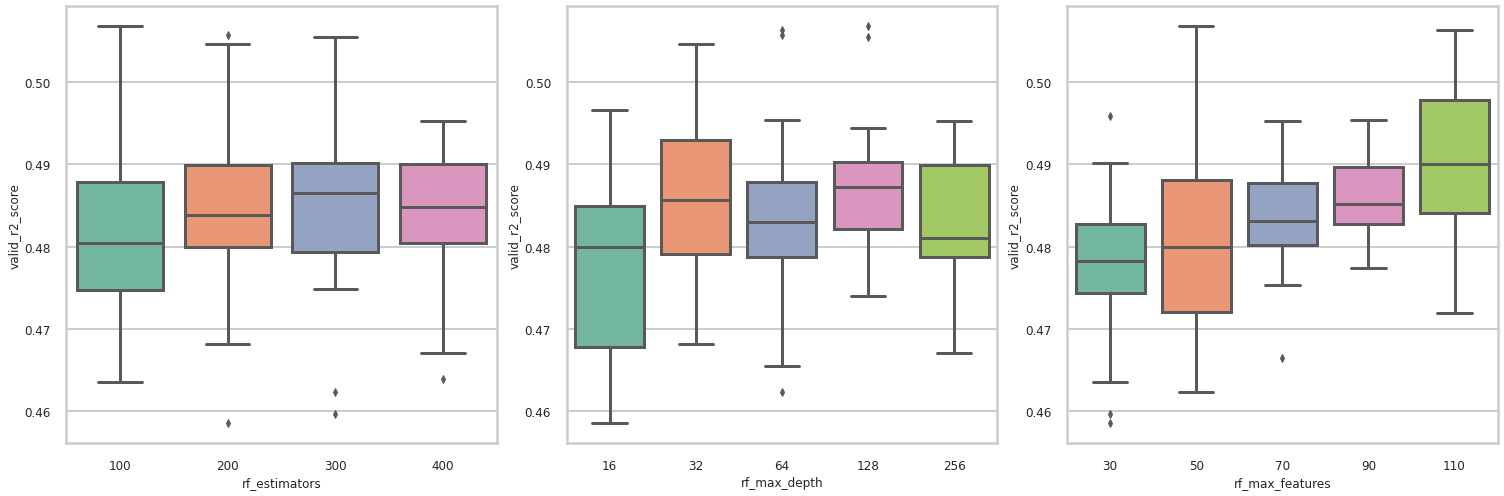

In [26]:
fig, ax = plt.subplots(1,3,figsize=(21,7))
sns.boxplot(data=perf_df, x="rf_estimators", y="valid_r2_score", ax=ax[0])
sns.boxplot(data=perf_df, x="rf_max_depth", y="valid_r2_score", ax=ax[1])
sns.boxplot(data=perf_df, x="rf_max_features", y="valid_r2_score", ax=ax[2])
fig.tight_layout()

## Random Search

In [ ]:
rfe_list = []
rfd_list = []
rff_list = []
valid_r2_list = []

num_trials = 50

for i in range(num_trials):
    params["rf_estimators"] = np.random.randint(8,256)
    params["rf_max_depth"] = np.random.randint(8,256)
    params["rf_max_features"] = np.random.randint(8,256)
    rfe_list.append(params["rf_estimators"])
    rfd_list.append(params["rf_max_depth"])
    rff_list.append(params["rf_max_features"])
    tp = parse.wrapper(params)
    pl = mp.ModelPipeline(tp)
    pl.train_model()
    pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
    pred_results = pred_data.get_prediction_results()
    valid_r2 = pred_results['r2_score']
    valid_r2_list.append(valid_r2)
    print(f"rf_estimators: {rf_estimator}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_r2: {valid_r2}")


number of features: 1024


2021-04-08 06:03:54,486 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
TIMING: dataset construction took 0.018 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:03:58,982 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/d97a7743-0773-42d1-8444-3f8907c44534/model_metadata.json
2021-04-08 06:03:59,166 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/d97a7743-0773-42d1-8444-3f8907c44534/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_d97a7743-0773-42d1-8444-3f8907c44534.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.4955063019086954
number of features: 1024


2021-04-08 06:04:07,131 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.083 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:04:08,600 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/9803ffc0-018f-44ca-9408-7c3213105ccb/model_metadata.json
2021-04-08 06:04:08,636 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/9803ffc0-018f-44ca-9408-7c3213105ccb/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_9803ffc0-018f-44ca-9408-7c3213105ccb.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.47191725761679426
number of features: 1024


2021-04-08 06:04:16,827 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.098 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.020 s
Loading dataset from disk.


2021-04-08 06:04:18,506 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/20242a81-0732-42d6-a8e5-623fd674cbaa/model_metadata.json
2021-04-08 06:04:18,574 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/20242a81-0732-42d6-a8e5-623fd674cbaa/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_20242a81-0732-42d6-a8e5-623fd674cbaa.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.4734698951645435
number of features: 1024


2021-04-08 06:04:26,784 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.085 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:04:32,014 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/db92728d-2db3-462e-934e-ea2efbd6abc7/model_metadata.json
2021-04-08 06:04:32,251 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/db92728d-2db3-462e-934e-ea2efbd6abc7/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_db92728d-2db3-462e-934e-ea2efbd6abc7.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.4968519311154763
number of features: 1024


2021-04-08 06:04:40,335 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:04:43,391 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/8da21692-d9b0-44fd-b4a0-23ced835b4e1/model_metadata.json
2021-04-08 06:04:43,505 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/8da21692-d9b0-44fd-b4a0-23ced835b4e1/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_8da21692-d9b0-44fd-b4a0-23ced835b4e1.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.4940606913900891
number of features: 1024


2021-04-08 06:04:51,501 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.085 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:04:56,275 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/64d7e478-f083-4710-8194-450bbb4685cb/model_metadata.json
2021-04-08 06:04:56,524 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/64d7e478-f083-4710-8194-450bbb4685cb/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_64d7e478-f083-4710-8194-450bbb4685cb.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.4926130631792026
number of features: 1024


2021-04-08 06:05:04,499 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.082 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.019 s
Loading dataset from disk.


2021-04-08 06:05:08,729 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/7a02143d-3225-40f7-b062-91e209fbd1ec/model_metadata.json
2021-04-08 06:05:08,911 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/7a02143d-3225-40f7-b062-91e209fbd1ec/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_7a02143d-3225-40f7-b062-91e209fbd1ec.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.49259820759804074
number of features: 1024


2021-04-08 06:05:16,753 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.091 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:05:19,905 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/61873366-8a57-4e94-be36-15215d43eb19/model_metadata.json
2021-04-08 06:05:20,052 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/61873366-8a57-4e94-be36-15215d43eb19/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_61873366-8a57-4e94-be36-15215d43eb19.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.4941067626251173
number of features: 1024


2021-04-08 06:05:27,835 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.082 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:05:33,333 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/6a5582e4-5f51-42cd-a254-ce9398b37ee0/model_metadata.json
2021-04-08 06:05:33,608 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/6a5582e4-5f51-42cd-a254-ce9398b37ee0/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_6a5582e4-5f51-42cd-a254-ce9398b37ee0.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.49556472845151067
number of features: 1024


2021-04-08 06:05:41,565 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.087 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:05:43,159 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/f143735e-8ece-495d-8062-ad2b7879d937/model_metadata.json
2021-04-08 06:05:43,207 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/f143735e-8ece-495d-8062-ad2b7879d937/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_f143735e-8ece-495d-8062-ad2b7879d937.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.4636681748390272
number of features: 1024


2021-04-08 06:05:51,148 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.091 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:05:54,302 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/a58a639b-650a-4955-9ae2-9642a7893cbe/model_metadata.json
2021-04-08 06:05:54,394 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/a58a639b-650a-4955-9ae2-9642a7893cbe/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_a58a639b-650a-4955-9ae2-9642a7893cbe.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.48079640892359987
number of features: 1024


2021-04-08 06:06:02,172 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.084 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:06:04,976 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/2550e5c2-47fd-4df0-9bea-767f9bd945c2/model_metadata.json
2021-04-08 06:06:05,126 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/2550e5c2-47fd-4df0-9bea-767f9bd945c2/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_2550e5c2-47fd-4df0-9bea-767f9bd945c2.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.47279925911093645
number of features: 1024


2021-04-08 06:06:13,026 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.083 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.


2021-04-08 06:06:16,898 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/4f4bd8de-54d8-4ba0-9dc4-14633734b19c/model_metadata.json
2021-04-08 06:06:17,036 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/4f4bd8de-54d8-4ba0-9dc4-14633734b19c/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_4f4bd8de-54d8-4ba0-9dc4-14633734b19c.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.5051097953626403
number of features: 1024


2021-04-08 06:06:24,736 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.081 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:06:25,839 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/13abdc81-e182-4cbb-b1bc-1b0e7982fca0/model_metadata.json
2021-04-08 06:06:25,860 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/13abdc81-e182-4cbb-b1bc-1b0e7982fca0/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_13abdc81-e182-4cbb-b1bc-1b0e7982fca0.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.4246099168134261
number of features: 1024


2021-04-08 06:06:33,666 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.081 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:06:38,048 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/bf8fdf4a-a727-43cc-8a8f-e186a2e0b87c/model_metadata.json
2021-04-08 06:06:38,239 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/bf8fdf4a-a727-43cc-8a8f-e186a2e0b87c/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_bf8fdf4a-a727-43cc-8a8f-e186a2e0b87c.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.49765710468958946
number of features: 1024


2021-04-08 06:06:45,859 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.080 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:06:47,651 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/eb1515aa-f575-4c67-86f6-9faec1e7db27/model_metadata.json
2021-04-08 06:06:47,715 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/eb1515aa-f575-4c67-86f6-9faec1e7db27/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_eb1515aa-f575-4c67-86f6-9faec1e7db27.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.492705598095565
number of features: 1024


2021-04-08 06:06:55,469 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.083 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:06:57,237 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/8b46553e-25a5-48cf-b2fe-c01dbbd1493f/model_metadata.json
2021-04-08 06:06:57,279 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/8b46553e-25a5-48cf-b2fe-c01dbbd1493f/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_8b46553e-25a5-48cf-b2fe-c01dbbd1493f.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.4621527487384205
number of features: 1024


2021-04-08 06:07:05,126 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:07:08,761 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/effb89b0-352a-4eb5-9e18-a3061a2ba2b6/model_metadata.json
2021-04-08 06:07:09,050 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/effb89b0-352a-4eb5-9e18-a3061a2ba2b6/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_effb89b0-352a-4eb5-9e18-a3061a2ba2b6.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.4570976719588681
number of features: 1024


2021-04-08 06:07:16,751 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.083 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:07:17,972 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/9adc8538-6427-4bd9-9fce-a04c5c2be1ca/model_metadata.json
2021-04-08 06:07:17,991 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/9adc8538-6427-4bd9-9fce-a04c5c2be1ca/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_9adc8538-6427-4bd9-9fce-a04c5c2be1ca.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.4278089785096194
number of features: 1024


2021-04-08 06:07:25,676 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.090 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:07:30,038 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/10401bea-a24c-4afb-b132-d2bdaafd997f/model_metadata.json
2021-04-08 06:07:30,326 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/10401bea-a24c-4afb-b132-d2bdaafd997f/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_10401bea-a24c-4afb-b132-d2bdaafd997f.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.4834706846676109
number of features: 1024


2021-04-08 06:07:38,304 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.088 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:07:39,839 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/c864af16-a22b-496b-b1a5-6605e4628a0b/model_metadata.json
2021-04-08 06:07:39,897 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/c864af16-a22b-496b-b1a5-6605e4628a0b/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_c864af16-a22b-496b-b1a5-6605e4628a0b.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.46910288457220173
number of features: 1024


2021-04-08 06:07:47,802 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.082 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:07:50,848 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/863e7ba5-5932-4e6a-b2ce-126d060ef0a2/model_metadata.json
2021-04-08 06:07:50,958 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/863e7ba5-5932-4e6a-b2ce-126d060ef0a2/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_863e7ba5-5932-4e6a-b2ce-126d060ef0a2.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.5169033555557339
number of features: 1024


2021-04-08 06:07:58,823 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.091 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:08:03,197 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/70cb23c0-5549-40e2-8fd7-fe87a4872665/model_metadata.json
2021-04-08 06:08:03,396 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/70cb23c0-5549-40e2-8fd7-fe87a4872665/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_70cb23c0-5549-40e2-8fd7-fe87a4872665.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.4764602238755389
number of features: 1024


2021-04-08 06:08:11,267 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.081 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.019 s
Loading dataset from disk.


2021-04-08 06:08:13,676 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/0bcd5e6a-42bf-40aa-9ced-d87fa26f4b1a/model_metadata.json
2021-04-08 06:08:13,830 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/0bcd5e6a-42bf-40aa-9ced-d87fa26f4b1a/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_0bcd5e6a-42bf-40aa-9ced-d87fa26f4b1a.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.468747244277097
number of features: 1024


2021-04-08 06:08:21,619 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.078 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:08:23,208 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/35395aa5-dc65-49d5-865f-157b5ba2ad26/model_metadata.json
2021-04-08 06:08:23,254 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/35395aa5-dc65-49d5-865f-157b5ba2ad26/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_35395aa5-dc65-49d5-865f-157b5ba2ad26.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.4455426637025589
number of features: 1024


2021-04-08 06:08:32,841 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.084 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:08:35,300 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/d969bbcc-f7dc-4034-8295-7f2805d2bda2/model_metadata.json
2021-04-08 06:08:35,435 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/d969bbcc-f7dc-4034-8295-7f2805d2bda2/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_d969bbcc-f7dc-4034-8295-7f2805d2bda2.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.48422094460459175
number of features: 1024


2021-04-08 06:08:43,345 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.081 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:08:47,075 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/39def827-8a7b-4213-807c-ffbef8908927/model_metadata.json
2021-04-08 06:08:47,291 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/39def827-8a7b-4213-807c-ffbef8908927/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_39def827-8a7b-4213-807c-ffbef8908927.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.4761757453866162
number of features: 1024


2021-04-08 06:08:55,229 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.083 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:08:57,610 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/16141116-cc9f-4997-add4-969ca4b6110e/model_metadata.json
2021-04-08 06:08:57,717 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/16141116-cc9f-4997-add4-969ca4b6110e/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_16141116-cc9f-4997-add4-969ca4b6110e.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.48486126378564043
number of features: 1024


2021-04-08 06:09:05,587 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.078 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:09:07,577 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/0e5131d6-f7aa-4104-8495-7eb8f3cbbcee/model_metadata.json
2021-04-08 06:09:07,639 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/0e5131d6-f7aa-4104-8495-7eb8f3cbbcee/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_0e5131d6-f7aa-4104-8495-7eb8f3cbbcee.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.48505108831041077
number of features: 1024


2021-04-08 06:09:15,522 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.086 s
Loading dataset from disk.
TIMING: dataset construction took 0.018 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2021-04-08 06:09:18,222 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/9886089f-3b9a-42e6-a94b-8a07e730aa21/model_metadata.json
2021-04-08 06:09:18,341 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/9886089f-3b9a-42e6-a94b-8a07e730aa21/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_9886089f-3b9a-42e6-a94b-8a07e730aa21.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.4951578280738972
number of features: 1024


2021-04-08 06:09:26,204 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.077 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:09:29,562 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/2dee8393-24f4-4709-8de0-9a4c7a96b3d4/model_metadata.json
2021-04-08 06:09:29,790 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/2dee8393-24f4-4709-8de0-9a4c7a96b3d4/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_2dee8393-24f4-4709-8de0-9a4c7a96b3d4.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.4806945068309373
number of features: 1024


2021-04-08 06:09:37,668 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.078 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.


2021-04-08 06:09:41,349 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/8b460111-90b7-4444-8559-46c04e5ce2fb/model_metadata.json
2021-04-08 06:09:41,505 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/8b460111-90b7-4444-8559-46c04e5ce2fb/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_8b460111-90b7-4444-8559-46c04e5ce2fb.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.4941315711219687
number of features: 1024


2021-04-08 06:09:49,244 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.081 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:09:51,480 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/32c118a9-f6d3-41e9-a979-eb0b249403d5/model_metadata.json
2021-04-08 06:09:51,606 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/32c118a9-f6d3-41e9-a979-eb0b249403d5/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_32c118a9-f6d3-41e9-a979-eb0b249403d5.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.4854622260865644
number of features: 1024


2021-04-08 06:09:59,373 Previous dataset split restored


n_cnt [1489.]
y_means [6.70065988]
y_stds [1.18359]
TIMING: dataset construction took 0.075 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


2021-04-08 06:10:03,324 Wrote model metadata to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/22a0f7bb-054b-423c-b4e7-bf3da92d70c5/model_metadata.json
2021-04-08 06:10:03,473 Wrote model metrics to file ampl_output/data_for_model/RF_ecfp_scaffold_regression/22a0f7bb-054b-423c-b4e7-bf3da92d70c5/model_metrics.json


Wrote model tarball to ampl_output/data_for_model_model_22a0f7bb-054b-423c-b4e7-bf3da92d70c5.tar.gz
rf_estimators: 100, rf_max_depth: 16, rf_max_features: 30, valid_r2: 0.48747407078132854


In [21]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_r2_score": valid_r2_list})
perf_df.sort_values(by="valid_r2_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
21,94,152,204,0.516903
12,123,47,241,0.505110
44,135,186,81,0.502760
39,34,162,210,0.497970
41,244,150,147,0.497860
14,165,67,194,0.497657
48,141,117,125,0.497244
45,64,199,175,0.496864
3,198,109,187,0.496852
47,202,61,205,0.496047


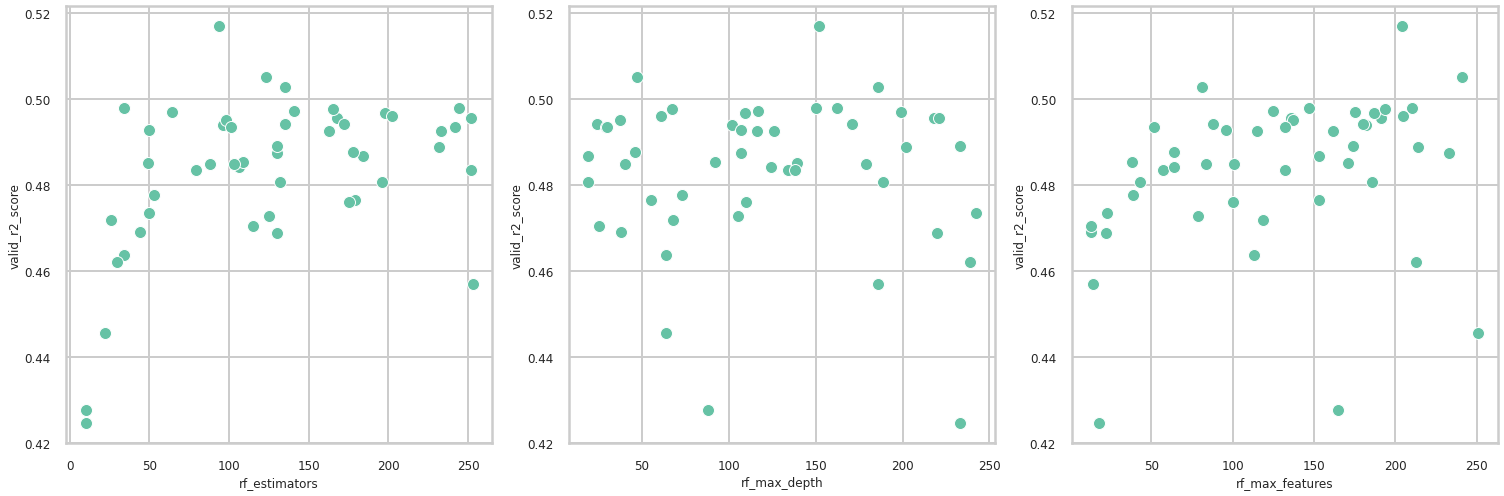

In [23]:

fig, ax = plt.subplots(1,3,figsize=(21,7))
sns.scatterplot(data=perf_df, x="rf_estimators", y="valid_r2_score", ax=ax[0])
sns.scatterplot(data=perf_df, x="rf_max_depth", y="valid_r2_score", ax=ax[1])
sns.scatterplot(data=perf_df, x="rf_max_features", y="valid_r2_score", ax=ax[2])
fig.tight_layout()